In [1]:
import os
import cv2
import numpy as np              
import pandas as pd      
import tensorflow as tf
import matplotlib.pyplot as plt 
from keras.layers import Dropout
from keras.layers import MaxPooling2D
from keras.layers import GlobalAveragePooling2D
from keras.models import load_model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import classification_report,confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense,Conv2D,Flatten,MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau

### Path of the dataset

In [2]:
size = (128,128,3)

# for train data
train_path = './dices'
#for test data 
test_path = './dice_test'


batch_size = 16



### Load Images

In [3]:
def load_images(path):
    
    images = []
    for file in os.listdir(path):
        img = cv2.imread(os.path.join(path,file))
        if img is not None:
            images.append(img)
    
    plt.figure(figsize=(15,8))    
    for img,x in zip(images,range(1,7)):
        plt.subplot(2,3,x)
        plt.imshow(img)

### Normal Dices

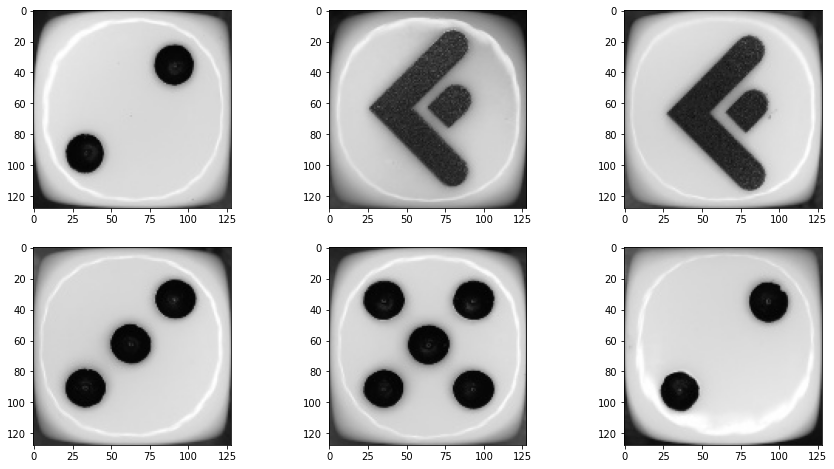

In [4]:
train_normal = './dices/normal'

load_images(train_normal)

### Abnormal Dices

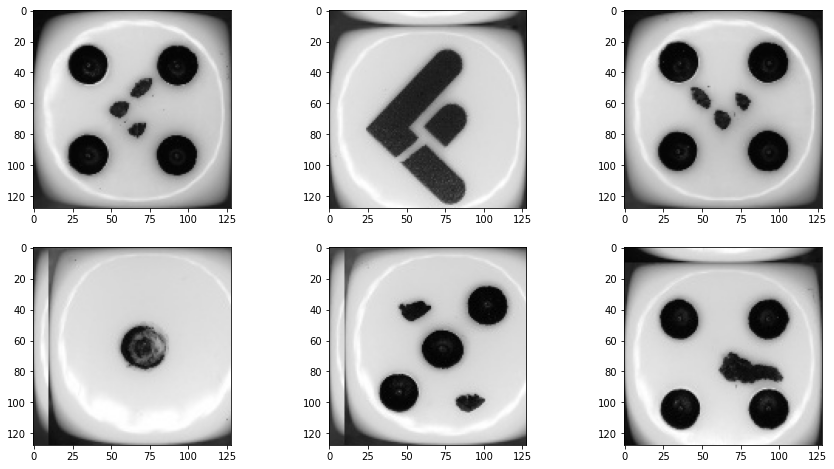

In [5]:
train_abnormal = './dices/abnormal'

load_images(train_abnormal)

### ImageDataGenerator

In [6]:
# Image Data Generator for train set

train_gen = ImageDataGenerator(
        validation_split=0.3, rescale=1/255
)

# Image Data Generator for test set

test_gen = ImageDataGenerator(
        validation_split=0.3, rescale=1/255
)

In [7]:
train = train_gen.flow_from_directory(
            train_path,
            target_size = (size[0], size[1]),
            batch_size = batch_size,
            class_mode = 'binary',
            shuffle = True,
            subset = 'training'
)

test = test_gen.flow_from_directory(
            test_path,
            target_size = (size[0], size[1]),
            batch_size = batch_size,
            class_mode = 'binary',
            shuffle = True,
            subset = 'validation'
)

Found 3470 images belonging to 2 classes.
Found 114 images belonging to 2 classes.


In [8]:
test.class_indices

{'abnormal': 0, 'normal': 1}

In [31]:
# CNN model with Squential
def create_model():
    model = Sequential()
    
    model.add(Conv2D(32, (3, 3), activation="relu",input_shape=(128,128,3)))
    model.add(MaxPooling2D())

    model.add(Conv2D(64, (3, 3), activation="relu"))
    model.add(MaxPooling2D())

    model.add(Conv2D(128, (3, 3), activation="relu"))
    model.add(MaxPooling2D())

    model.add(Conv2D(128, (3, 3), activation="relu"))
    model.add(MaxPooling2D())
    
    model.add(Flatten())
    model.add(Dense(512,activation='relu'))

    model.add(Dense(1,activation='softmax'))

    
    opt = Adam(lr=0.000001)
    model.compile(optimizer = opt , loss='binary_crossentropy',metrics=['accuracy'])
    
    return model


In [32]:
# Create a basic model instance
model = create_model()



In [33]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 63, 63, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_21 (Conv2D)          (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 30, 30, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_22 (Conv2D)          (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 14, 14, 128)     

In [34]:
#save the model
checkpoint_path = "binary.h5"
checkpoint_dir = os.path.dirname(checkpoint_path)

# create callbacks with check point
callbacks = [EarlyStopping(monitor='val_loss', patience=2),
             ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True, monitor='val_loss')]


In [35]:
#start to model fitting
history = model.fit(train, epochs = 5 , validation_data = test, callbacks = callbacks)


Epoch 1/5
217/217 [==============================] - 64s 292ms/step - loss: 0.6610 - accuracy: 0.6865 - val_loss: 0.5715 - val_accuracy: 0.8684
Epoch 2/5
217/217 [==============================] - 59s 273ms/step - loss: 0.6203 - accuracy: 0.6865 - val_loss: 0.5072 - val_accuracy: 0.8684
Epoch 3/5
217/217 [==============================] - 76s 352ms/step - loss: 0.6055 - accuracy: 0.6865 - val_loss: 0.4891 - val_accuracy: 0.8684
Epoch 4/5
217/217 [==============================] - 80s 369ms/step - loss: 0.5964 - accuracy: 0.6865 - val_loss: 0.4772 - val_accuracy: 0.8684
Epoch 5/5
217/217 [==============================] - 90s 416ms/step - loss: 0.5872 - accuracy: 0.6865 - val_loss: 0.4750 - val_accuracy: 0.8684


<AxesSubplot:>

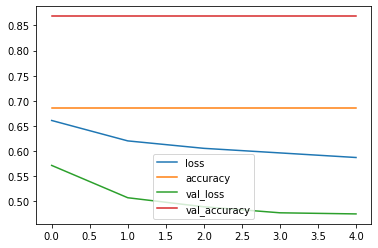

In [36]:
# Plot the model
pd.DataFrame(history.history).plot()


In [40]:
# Re-evaluate the model
loss, acc = model.evaluate(test, verbose=2)
print("Restored model, accuracy: {:5.2f}%".format(100 * acc))

8/8 - 1s - loss: 0.4750 - accuracy: 0.8684 - 553ms/epoch - 69ms/step
Restored model, accuracy: 86.84%


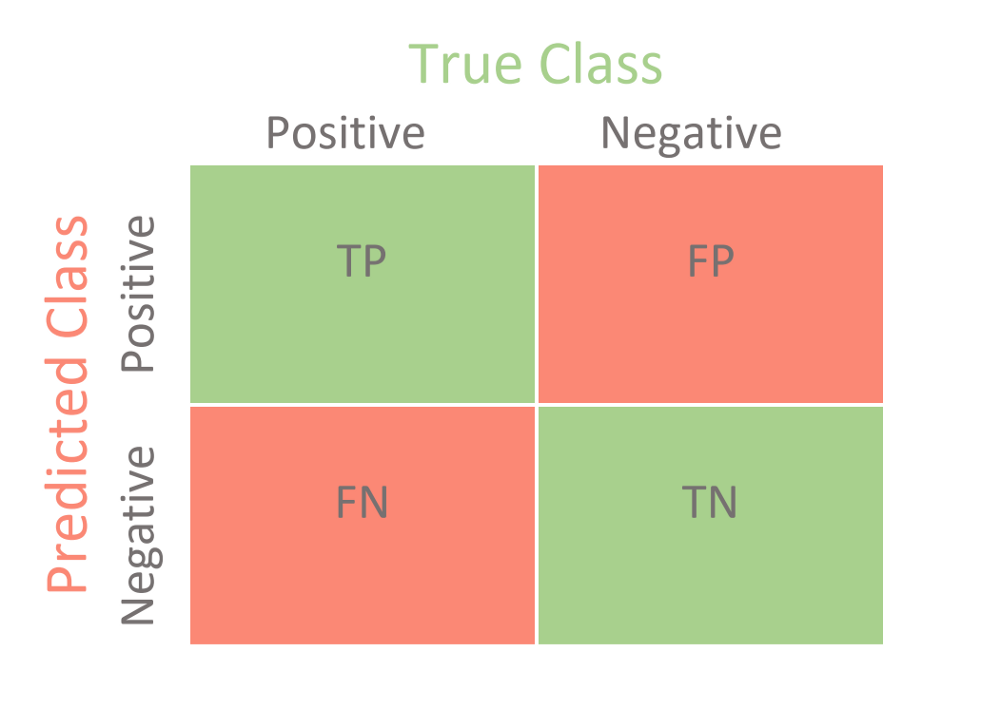



- Precision = TruePositives / (TruePositives + FalsePositives)
- Recall = TruePositives / (TruePositives + FalseNegatives)
- F1 = (2 * Precision * Recall) / (Precision + Recall)

In [54]:
def predict(filename):
    img1 = image.load_img(filename,target_size=(128,128))
    
    plt.imshow(img1)
 
    Y = image.img_to_array(img1)
    
    X = np.expand_dims(Y,axis=0)
    val = model.predict(X)
    print(val)
    if val == 1:
        
        plt.xlabel("Normal")
        
    
    elif val == 0:
        
        plt.xlabel("Abnormal")


In [55]:
path = './dices/normal/26_01_22_10_106.png'

[[1.]]


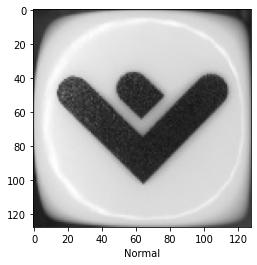

In [56]:
predict(path)

[[1.]]


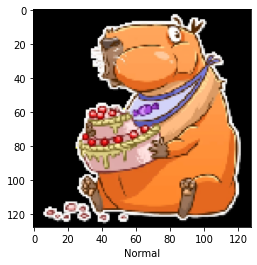

In [57]:
path = './test/pngegg (8).png'
predict(path)

[[1.]]


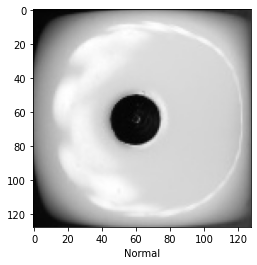

In [58]:
path = './test/unknown.png'
predict(path)

There are three main approaches which are suggested each having its pros and cons:

- **Undersampling**- Randomly delete the class which has sufficient observations so that the comparative ratio of two classes is significant in our data.Although this approach is really simple to follow but there is a high possibility that the data that we are deleting may contain important information about the predictive class.

- **Oversampling**-For the unbalanced class randomly increase the number of observations which are just copies of existing samples.This ideally gives us sufficient number of samples to play with.The oversampling may lead to overfitting to the training data
- **Synthetic sampling(SMOTE)**-The technique asks to synthetically manufacture observations of unbalanced classes which are similar to the existing using nearest neighbors classification.The problem is what to do when the number of observations of is an extremely rare class .For example-we may have only one picture of a rare species which we want to identify using image classification algorithm

Applying regularization helps you to:

**Reduce the effects of overfitting**
**Increase the ability of your model to generalize**

When working with large datasets and deep neural networks applying regularization is typically a must.

Normally you’ll encounter either L1 or L2 regularization being applied — I will use L2 regularization on my networks if I detect signs of overfitting:

EarlyStopping is another method to avoid overfitting

